In [1]:
!pip3 install matplotlib tensorflow tensorflow_addons opencv-python tqdm tensorflow-hub numpy tensorflow

In [2]:
!ls /data3/awong/pano/M3D_test/depth | wc -l

1527


In [3]:
from zipfile import ZipFile
import pandas as pd
import os, time
import shutil
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import random
from tqdm.notebook import tqdm, trange

os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import cv2

2022-03-02 10:05:19.007676: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.InteractiveSession(config=config)

def loss_function(y_true, y_pred):

  #Cosine distance loss
  l_depth = K.mean(K.abs(y_pred - y_true), axis=-1)
  
  # edge loss for sharp edges
  dy_true, dx_true = tf.image.image_gradients(y_true)
  dy_pred, dx_pred = tf.image.image_gradients(y_pred)
  l_edges = K.mean(K.abs(dy_pred - dy_true) + K.abs(dx_pred - dx_true), axis=-1)
  
  # structural similarity loss
  l_ssim = K.clip((1 - tf.image.ssim(y_true, y_pred, 1.0)) * 0.5, 0, 1)

  # weightage
  w1, w2, w3 = 1.0, 1.0, 0.1
  return (w1 * l_ssim) + (w2 * K.mean(l_edges)) + (w3 * K.mean(l_depth))

# accuracy function
def accuracy_function(y_true, y_pred):
  return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

/data/awong189/miniconda/envs/tensorflow/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.4.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(
2022-03-02 10:05:20.934299: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4

In [5]:
def load_depth(filename, flip, size=(256,128), max_depth=8.0, **kwargs):
    if 'position' in kwargs:
        filename = filename.replace('center', kwargs['position'])
    depth_filename = filename.replace('emission', 'depth').replace('.png', '.exr')
    if 'filmic' in depth_filename.split(os.sep)[-3]:
        depth_filename = depth_filename.replace('_filmic', '')

    depth = cv2.imread(depth_filename, cv2.IMREAD_ANYDEPTH)
#     depth = cv2.resize(depth, size)

    if flip:
        depth = cv2.flip(depth, 1)

    depth = np.expand_dims(depth, axis=-1)

    #NOTE: add a micro meter to allow for thresholding to extact the valid mask
    depth[depth > max_depth] = max_depth + 1e-6

    # depth = tf.convert_to_tensor(depth)
    # depth = tf.expand_dims(depth, 0)

    return depth

def load_color(filename, flip, **kwargs):
    if 'position' in kwargs:
        filename = filename.replace('center', kwargs['position'])
    image = tf.io.read_file(filename)
    image = tf.io.decode_image(image, channels=3, expand_animations = False)
    image = tf.cast(image, tf.float32)

    if flip:
        image = tf.image.flip_left_right(image)

    return image.numpy()

In [6]:
def return_prediction(model, num=0):
    depth_image = load_depth("/data3/awong/pano/M3D_test/depth/%d.exr"%num, False)
    depth_scaled = (depth_image - depth_image.min()) / (depth_image.max() - depth_image.min())

    image = load_color("/data3/awong/pano/M3D_test/image/%d.png"%num, False)
    scaled = (image - image.min()) / (image.max() - image.min())
    preds = model.predict(np.expand_dims(scaled, axis=0))
    return preds, depth_scaled, scaled

In [7]:
def abs_rel_err(pred, expected):
    return np.mean(np.divide(np.abs(pred - expected), expected))

def sq_rel_err(pred, expected):
    return np.mean(np.divide(np.square(pred - expected), expected))

def root_mean_sq_err(pred, expected):
    return np.sqrt(np.mean((pred-expected)**2))

def root_mean_sq_err_log(pred, expected):
    return np.sqrt(np.mean((np.log2(pred)-np.log2(expected))**2))

# https://github.com/nianticlabs/monodepth2/blob/master/evaluate_depth.py
def compute_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)

    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

def calculate_errors(model, num=1527):
    absrel = 0
    sqrel = 0
    rmse = 0
    rmse_log = 0
    a1 = 0
    a2 = 0
    a3 = 0
    
    for i in trange(num):
        preds, depth, _ = return_prediction(model, i)
        preds += 1e-7
        depth += 1e-7
        
#         absrel += abs_rel_err(preds[0], depth)
#         sqrel += sq_rel_err(preds[0], depth)
#         rmse += root_mean_sq_err(preds[0], depth)
#         rmse_log += root_mean_sq_err_log(preds[0], depth)

        ab, sq, rm, rm_log, _a1, _a2, _a3 = compute_errors(depth, preds)
        absrel += ab
        sqrel += sq
        rmse += rm
        rmse_log += rm_log
        a1 += _a1
        a2 += _a2
        a3 += _a3
        
    print("Abs Rel: %0.2f | Sq Rel: %0.2f | RMSE: %0.2f | RMSE log: %0.2f | a1: %0.2f | a2: %0.2f | a3: %0.2f" % (absrel / num, sqrel / num, rmse / num, rmse_log / num, a1 / num, a2 / num, a3 / num))

# MobileNet

In [15]:
custom_func = {"loss_function": loss_function, "accuracy_function": accuracy_function}
model = tf.keras.models.load_model('../networks/unet-mobilenet-pano2.h5', custom_objects=custom_func)

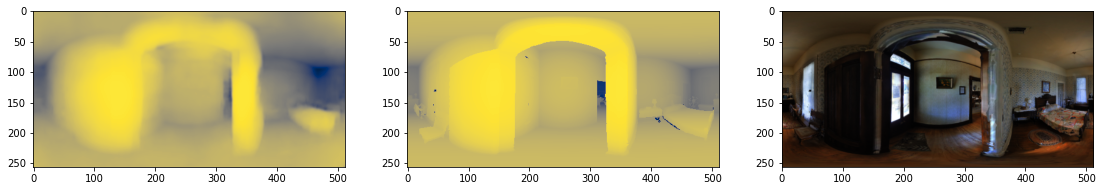

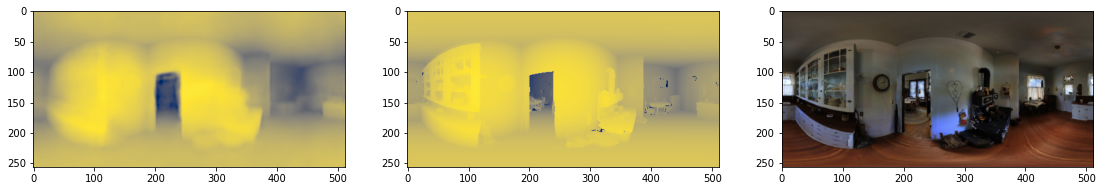

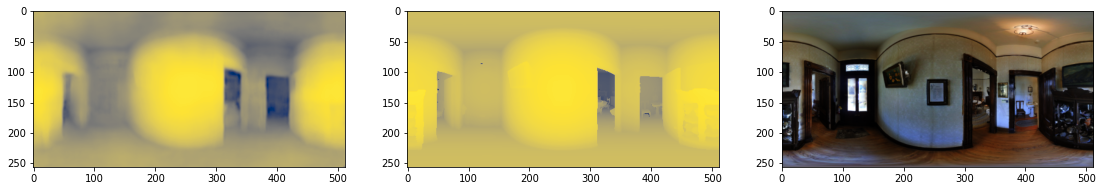

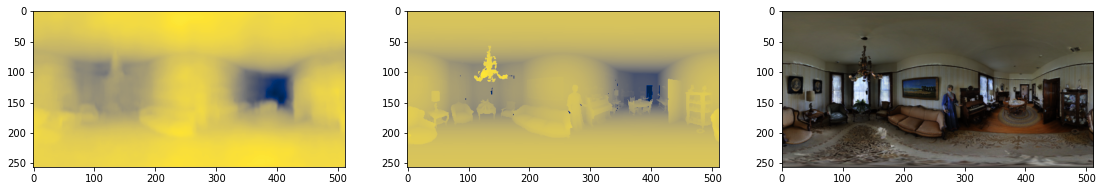

In [19]:
for i in range(4):
    preds, depth_scaled, scaled = return_prediction(model, i)

    plt.figure(figsize=(19,10))
    plt.subplot(1,3,1)
    plt.imshow(preds.squeeze(), cmap='cividis_r')
    plt.subplot(1,3,2)
    plt.imshow(depth_scaled.squeeze(), cmap='cividis_r')
    plt.subplot(1,3,3)
    plt.imshow(scaled)

In [17]:
calculate_errors(model)

  0%|          | 0/1527 [00:00<?, ?it/s]

Abs Rel: 12.06 | Sq Rel: 1.11 | RMSE: 0.09 | RMSE log: 0.54 | a1: 0.51 | a2: 0.76 | a3: 0.87


# DenseDepth

In [20]:
custom_func = {"loss_function": loss_function, "accuracy_function": accuracy_function}
model = tf.keras.models.load_model('../networks/unet-densedepth-pano1.h5', custom_objects=custom_func)

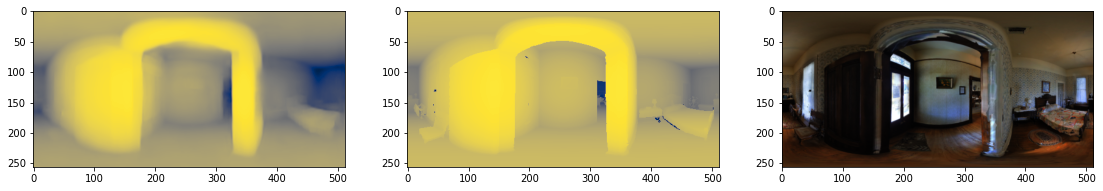

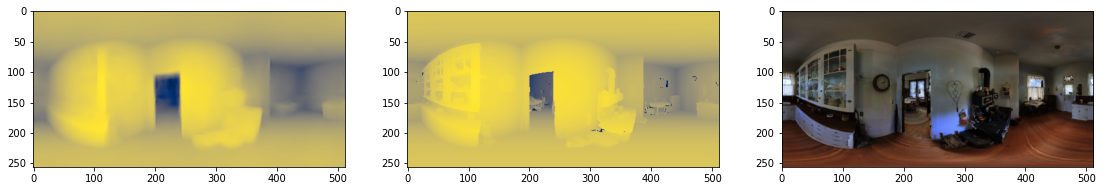

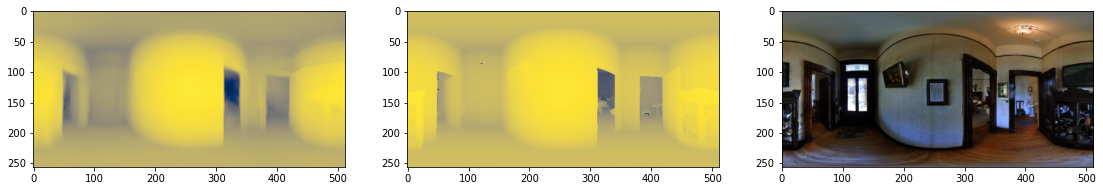

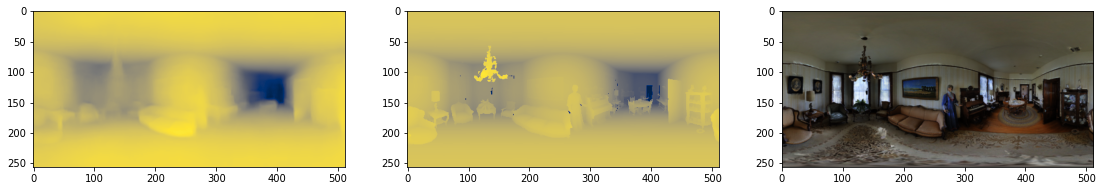

In [21]:
for i in range(4):
    preds, depth_scaled, scaled = return_prediction(model, i)

    plt.figure(figsize=(19,10))
    plt.subplot(1,3,1)
    plt.imshow(preds.squeeze(), cmap='cividis_r')
    plt.subplot(1,3,2)
    plt.imshow(depth_scaled.squeeze(), cmap='cividis_r')
    plt.subplot(1,3,3)
    plt.imshow(scaled)

In [10]:
calculate_errors(model)

  0%|          | 0/1527 [00:00<?, ?it/s]

Abs Rel: 8.42 | Sq Rel: 1.12 | RMSE: 0.08 | RMSE log: 0.45 | a1: 0.63 | a2: 0.84 | a3: 0.91


# EfficientNet

In [22]:
custom_func = {"loss_function": loss_function, "accuracy_function": accuracy_function}
model = tf.keras.models.load_model('../networks/unet-efficient-pano2.h5', custom_objects=custom_func)

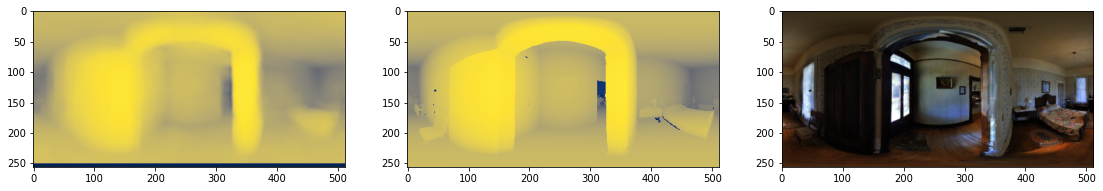

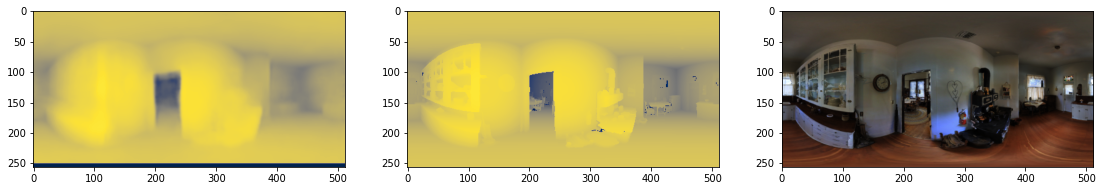

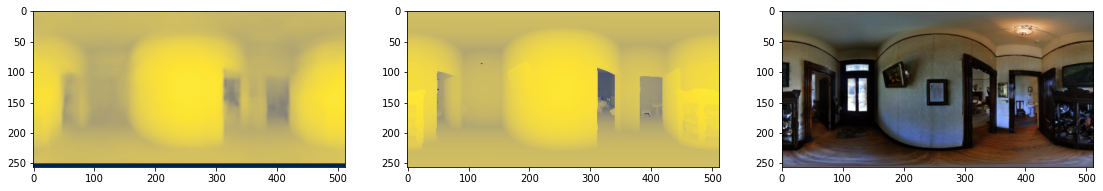

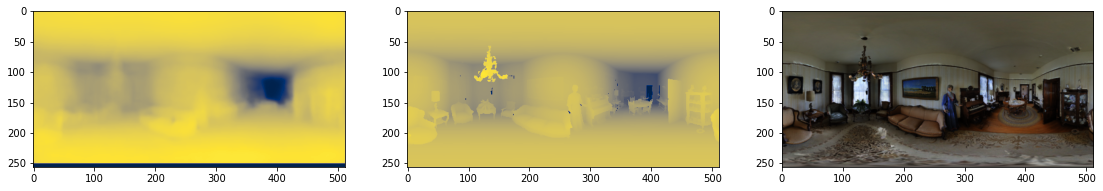

In [23]:
for i in range(4):
    preds, depth_scaled, scaled = return_prediction(model, i)

    plt.figure(figsize=(19,10))
    plt.subplot(1,3,1)
    plt.imshow(preds.squeeze(), cmap='cividis_r')
    plt.subplot(1,3,2)
    plt.imshow(depth_scaled.squeeze(), cmap='cividis_r')
    plt.subplot(1,3,3)
    plt.imshow(scaled)

In [14]:
calculate_errors(model)

  0%|          | 0/1527 [00:00<?, ?it/s]

Abs Rel: 36.94 | Sq Rel: 30.34 | RMSE: 0.16 | RMSE log: 0.59 | a1: 0.58 | a2: 0.80 | a3: 0.88


# Optimized MobileNetv2 with LIST

In [12]:
from ../utils import DownSampling

SyntaxError: invalid syntax (1792905178.py, line 1)

In [9]:
custom_func = {"loss_function": loss_function, "accuracy_function": accuracy_function, "DownSampling": }
model = tf.keras.models.load_model('../networks/unet-optimized-pano1.h5', custom_objects=custom_func)

ValueError: Unknown layer: DownSampling

In [ ]:
for i in range(4):
    preds, depth_scaled, scaled = return_prediction(model, i)

    plt.figure(figsize=(19,10))
    plt.subplot(1,3,1)
    plt.imshow(preds.squeeze(), cmap='cividis_r')
    plt.subplot(1,3,2)
    plt.imshow(depth_scaled.squeeze(), cmap='cividis_r')
    plt.subplot(1,3,3)
    plt.imshow(scaled)

# MiDaS

In [10]:
import tensorflow as tf
import tensorflow_hub as hub

img = cv2.imread('./M3D_test/image/0.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0

img_resized = tf.image.resize(img, [256,256], method='bicubic', preserve_aspect_ratio=False)
img_resized = tf.transpose(img_resized, [2, 0, 1])
img_input = img_resized.numpy()
reshape_img = img_input.reshape(1,3,256,256)
tensor = tf.convert_to_tensor(reshape_img, dtype=tf.float32)

module = hub.load("https://tfhub.dev/intel/midas/v2_1_small/1", tags=['serve'])
output = module.signatures['serving_default'](tensor)
prediction = output['default'].numpy()
prediction = prediction.reshape(256, 256)

prediction = cv2.resize(prediction, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
print(" Write image to: output.png")
depth_min = prediction.min()
depth_max = prediction.max()
img_out = (255 * (prediction - depth_min) / (depth_max - depth_min)).astype("uint8")


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


ResourceExhaustedError: Graph execution error:

Detected at node 'BatchNormalization_86/sub' defined at (most recent call last):
    File "/opt/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/opt/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/opt/anaconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
      app.start()
    File "/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
      self.io_loop.start()
    File "/opt/anaconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/opt/anaconda3/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/opt/anaconda3/lib/python3.8/site-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "/opt/anaconda3/lib/python3.8/site-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/opt/anaconda3/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2894, in run_cell
      result = self._run_cell(
    File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3165, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3357, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3437, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-10-f537159f90fa>", line 13, in <module>
      module = hub.load("https://tfhub.dev/intel/midas/v2_1_small/1", tags=['serve'])
    File "//home/awong189/.local/lib/python3.8/site-packages/tensorflow_hub/module_v2.py", line 106, in load
      obj = tf.compat.v1.saved_model.load_v2(module_path, tags=tags)
Node: 'BatchNormalization_86/sub'
OOM when allocating tensor of shape [1,576,1,1] and type float
	 [[{{node BatchNormalization_86/sub}}]] [Op:__inference_pruned_116757]

In [ ]:
plt.imshow(img_out, cmap="plasma_r")